# Fully Convolutional DenseNets for Semantic Segmentation

## Overview

* [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326)
* [CamVid site](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/)
* [CamVid dataset](https://github.com/mostafaizz/camvid)

### Classes

![](LabelsColorKey.jpg)

## Data

In [121]:
%matplotlib inline
import importlib
import utils; importlib.reload(utils)
from utils import segment_generator
from PIL import Image
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

In [8]:
PATH = '/home/mark/data/datasets/cv/camvid/'
label_path = PATH+'LabeledApproved_full/'
frames_path = PATH+'701_StillsRaw_full/'

In [12]:
fnames = glob(frames_path+'*.png'); len(fnames)

701

In [40]:
# Image.open(fnames[0])

In [15]:
lnames = [label_path+os.path.basename(fn)[:-4]+'_L.png' for fn in fnames]; len(lnames)

701

In [41]:
# Image.open(lnames[0])

### Image resizing

Images in the dataset vary in size and are generally quite large –> resize for training

In [42]:
image_size = (480, 360)

In [43]:
def resize_image(fn): return np.array(Image.open(fn).resize(image_size, Image.NEAREST))

In [44]:
images = np.stack([resize_image(fn) for fn in fnames])

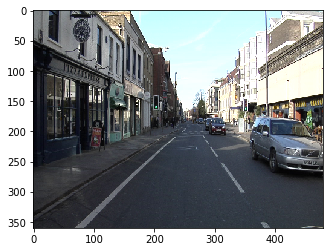

In [51]:
plt.imshow(images[0])

In [45]:
labels = np.stack([resize_image(fn) for fn in lnames])

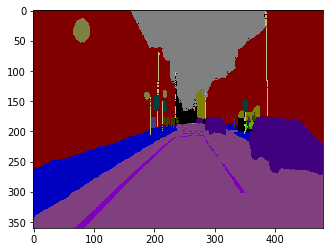

In [52]:
plt.imshow(labels[0])

In [46]:
images.shape, labels.shape

((701, 360, 480, 3), (701, 360, 480, 3))

In [119]:
n_imgs, rows, columns, channels = images.shape

### Image Preprocessing

The paper uses random cropping (224x224) and horizontal flipping for data augmentation for training

In [56]:
sg = segment_generator(images, labels, 4, train=False)

In [62]:
b_img, b_label = next(sg)

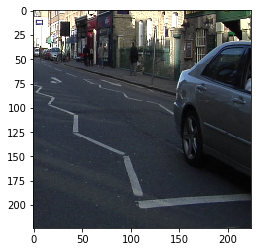

In [64]:
plt.imshow(b_img[0])

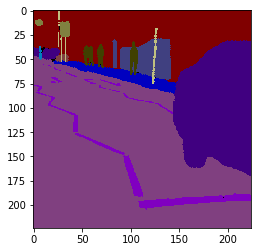

In [126]:
plt.imshow(b_label[0].reshape(224, 224, 3))

### Convert labels

Convert segmented targets into integers for classification.

The dataset contains a label_colors.txt file with a RGB - Entity mapping. Example:

    `64 128 64	Animal`

In [113]:
def parse_code(line):
    color, label = line.strip().split('\t')
    return tuple(int(o) for o in color.split(' ')), label

In [114]:
label_codes, label_names = zip(*[parse_code(line) for line in open(PATH+'label_colors.txt')])

In [115]:
label_codes, label_names = list(label_codes), list(label_names)

Map each color code (rgb) color to int

In [116]:
code2id = {v:k for k,v in enumerate(label_codes)}

Add code for erroneous pixel values

In [117]:
failed_code = len(label_codes)+1
label_codes.append((0,0,0))
label_names.append('UNK')

In [120]:
def convert_label(i):
    res = np.zeros((rows, columns), 'uint8')
    for j in range(rows):
        for k in range(columns):
            try: res[j, k] = code2id[tuple(labels[i, j, k])]
            except: res[j, k] = failed_code
    return res

In [122]:
def convert_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(convert_label, range(n_imgs)))

In [123]:
%time labels_int = convert_all_labels()

CPU times: user 360 ms, sys: 160 ms, total: 520 ms
Wall time: 1min 26s


Set erroneous pixels to zero

In [125]:
labels_int[labels_int==failed_code]=0

The paper uses a 367 frames for training, 101 frames for validation and 223 frames for test

In [129]:
train = images[:367]
train_labels = labels_int[:367]
val = images[367:468]
val_labels = labels_int[367:468]
test = images[468:]
test_labels = labels_int[468:]

In [131]:
train.shape, val.shape, test.shape

((367, 360, 480, 3), (101, 360, 480, 3), (233, 360, 480, 3))

## Model

In [173]:
from keras.layers import BatchNormalization, Activation, Dropout, Conv2D
from keras.layers import concatenate, Deconv2D, MaxPool2D, Input, Reshape
from keras.regularizers import l2
from keras.models import Model

* initialized using HeUniform
* optimized using RMSProp w/ initial learning rate of 1e-3 and an exponential decay of 0.995
* regularized using weight decay of 1e-4 and a dropout rate of 0.2
* batch normalization is used with current batch statistics
* growth rate of 16
* batch size of 3
* 11 semantic classes (+ UNK)

### Components

#### Dense Block

In [189]:
def layer(x, filters, d_rate=0.2, w_decay=1e-4):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters,
               kernel_size=3,
               kernel_regularizer=l2(w_decay),
               kernel_initializer='he_uniform',
               padding='same')(x)
    x = Dropout(d_rate)(x)
    return x

In [158]:
def dense_block(x, growth_rate=16, n_layers=4, d_rate=0.2, w_decay=1e-4):
    layers = []
    for i in range(n_layers):
        l = layer(x, growth_rate, d_rate, w_decay)
        layers.append(l)
        x = concatenate([x, l])
    return x, layers     

#### Transition Down

In [192]:
def trans_down(x, d_rate=0.2, w_decay=1e-4):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(x.get_shape().as_list()[-1],
               1,
               kernel_regularizer=l2(w_decay),
               kernel_initializer='he_uniform',
               padding='same')(x)
    x = Dropout(d_rate)(x)
    x = MaxPool2D()(x)
    return x

#### Down Path (Downsample)

In [160]:
def down_path(x, blocks, growth_rate, d_rate, w_decay):
    skips = []
    for i, n in enumerate(blocks):
        x, layers = dense_block(x, growth_rate, n, d_rate)
        skips.append(x)
        x = trans_down(x, d_rate, w_decay)
    return skips, layers

#### Transition Up

In [169]:
def trans_up(added, w_decay=1e-4):
    x = concatenate(added)
    _, rows, columns, channels = x.get_shape().as_list()
    x = Deconv2D(channels, 3, strides=(2,2), padding='same',
                 kernel_regularizer=l2(w_decay), kernel_initializer='he_uniform')(x)
    return x

#### Up Path (Upsample)

In [199]:
def up_path(added, skips, blocks, growth_rate, d_rate, w_decay):
    for i, n in enumerate(blocks):
        x = trans_up(added, w_decay)
        print(x.get_shape())
        x = concatenate([x, skips[i]])
        x, layers = dense_block(x, growth_rate, n, d_rate, w_decay)
    return x

### Architecture

In [200]:
def reverse(a): return list(reversed(a))

In [206]:
def create_network(n_classes, inp, n_dense_blocks=6,
                   growth_rate=16, n_filters=48, n_layers_per_block=4, d_rate=0, w_decay=0):
    
    if type(n_layers_per_block) is list or type(n_layers_per_block) is tuple:
        blocks = list(n_layers_per_block)
    else:
        blocks = [n_layers_per_block] * n_dense_blocks
    
    x = Conv2D(n_filters, 3, kernel_regularizer=l2(w_decay), padding='same')(inp)
    skips, added = down_path(x, blocks, growth_rate, d_rate, w_decay)
    print(added)
    x = up_path(added, reverse(skips[:-1]), reverse(blocks[:-1]), growth_rate, d_rate, w_decay)
    x = Conv2D(n_classes, 1, kernel_regularizer=l2(w_decay))(x)
    
    _, rows, columns, channels = x.get_shape().as_list()
    x = Reshape((-1, n_classes))(x)
    out = Activation('softmax')(x)

### Train

In [207]:
input_shape = (224, 224, 3)

In [208]:
img_input = Input(shape=input_shape)

In [209]:
n_layers_per_block = [4, 5, 7, 10, 12, 15]

In [210]:
x = create_network(12, img_input, n_layers_per_block=n_layers_per_block, d_rate=0.2, w_decay=1e-4)

[<tf.Tensor 'dropout_189/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_190/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_191/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_192/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_193/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_194/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_195/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_196/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_197/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_198/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_199/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_200/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_201/cond/Merge:0' shape=(?, 7, 7, 16) dtype=float32>, <tf.Tensor 'dropout_202/cond/Merge:0'

ValueError: `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 14, 14, 240), (None, 28, 28, 464)]